load and process data


In [6]:
import os

data_dir = 'leapGestRecog'

if not os.path.exists(data_dir):
    print("❌ The folder 'leapGestRecog' does not exist.")
else:
    print(f"✅ Found folder: {data_dir}")
    contents = os.listdir(data_dir)
    print(f"Contains {len(contents)} items:\n", contents)

    for folder in contents:
        folder_path = os.path.join(data_dir, folder)
        print(f"\n📁 Subfolder: {folder}")
        if not os.path.isdir(folder_path):
            print("  ⚠️ Not a folder, skipping.")
            continue

        files = os.listdir(folder_path)
        print(f"  Contains {len(files)} files. Sample: {files[:5]}")


✅ Found folder: leapGestRecog
Contains 10 items:
 ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']

📁 Subfolder: 00
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 01
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 02
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 03
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 04
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 05
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 06
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 07
  Contains 10 files. Sample: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb']

📁 Subfolder: 08
  Contains 10 files. Sam

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Set data path
data_dir = 'leapGestRecog'

images, labels = [], []

if not os.path.exists(data_dir):
    raise ValueError(f"Data directory '{data_dir}' does not exist.")

# Traverse user folders like '00', '01', ..., '09'
for user_folder in os.listdir(data_dir):
    user_path = os.path.join(data_dir, user_folder)
    if not os.path.isdir(user_path):
        continue

    # Traverse gesture folders like '01_palm', '02_l', ...
    for gesture_folder in os.listdir(user_path):
        gesture_path = os.path.join(user_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        # Read images in gesture folder
        for file in os.listdir(gesture_path):
            if file.lower().endswith('.png'):
                img_path = os.path.join(gesture_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not load image: {img_path}")
                    continue
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(gesture_folder.split('_')[0])  # '01_palm' → '01'

print(f"✅ Loaded {len(images)} images and {len(labels)} labels.")
print("Unique labels found:", sorted(set(labels)))

# Check if any data was loaded
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No valid images or labels found.")

# Normalize and reshape
X = np.array(images).astype('float32') / 255.0
X = X.reshape(-1, 64, 64, 1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data preprocessing complete.")
print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


✅ Loaded 20000 images and 20000 labels.
Unique labels found: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
✅ Data preprocessing complete.
Training shape: (16000, 64, 64, 1), (16000, 10)
Test shape: (4000, 64, 64, 1), (4000, 10)


Build The CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 gesture classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\jhasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,914 (2.61 MB)

 Trainable params: 683,914 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Train The Model

In [9]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1)


Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 182s 787ms/step - accuracy: 0.5982 - loss: 1.1499 - val_accuracy: 0.9975 - val_loss: 0.0185
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 708ms/step - accuracy: 0.9816 - loss: 0.0592 - val_accuracy: 0.9975 - val_loss: 0.0080
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 167s 742ms/step - accuracy: 0.9924 - loss: 0.0266 - val_accuracy: 0.9962 - val_loss: 0.0112
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 567ms/step - accuracy: 0.9908 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 148s 593ms/step - accuracy: 0.9963 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 1.7901e-04
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 143s 635ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.9994 - val_loss: 9.7289e-04
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 5.8519e-05
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 219s 836ms/step - accuracy:

Evaluate Performance

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9994 - loss: 0.0027
Test Accuracy: 99.95%


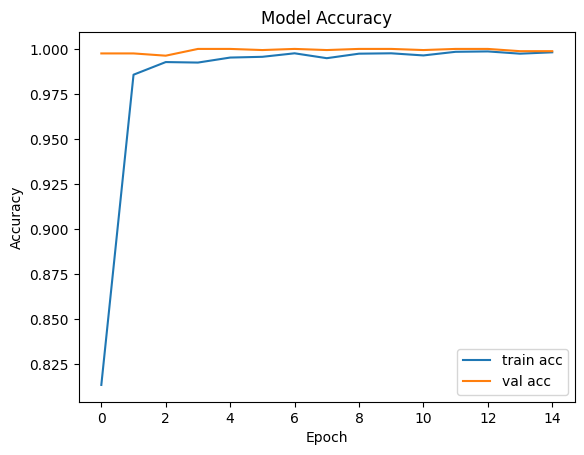

In [10]:
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


SAve and Use the Model

In [14]:
# Save model
model.save('gesture_recognition_model.h5')

# Predict function for a new image
def predict_gesture(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64)).astype('float32') / 255.0
    img = img.reshape(1, 64, 64, 1)
    pred = model.predict(img)
    return le.inverse_transform([np.argmax(pred)])

# Example
print(predict_gesture('photo-1600821462314-9dcebd4e7a2f.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
['05']
